<a href="https://colab.research.google.com/github/zbiswas3/Datascience-Projects/blob/master/NN_Posture_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve, validation_curve, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import  SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set(rc={'figure.figsize':(12,8.5)})
sns.set_context('poster', font_scale=0.75)

#INTRODUCTION

## **Utils**

In [ ]:
# validatiion curve
def valid_plot(
    X, 
    y, 
    param_range, 
    param_name, 
    estimator, 
    xlabel="parameter", 
    ylabel="accuracy score",  
    title="Validation Curve"
    ):
  train_scores, test_scores = validation_curve(
      estimator,
      X,
      y,
      param_name=param_name,
      param_range=param_range,
      scoring="accuracy",
      n_jobs=2,
      cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
  )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  # plt.ylim(0.0, 1.1)
  lw = 2
  plt.plot(
      param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
  )
  plt.fill_between(
      param_range,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.2,
      color="darkorange",
      lw=lw,
  )
  plt.plot(
      param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
  )
  plt.fill_between(
      param_range,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.2,
      color="navy",
      lw=lw,
  )
  plt.legend(loc="best")
  return plt


In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(26, 8))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


In [ ]:
# Calculate bias and variance of the model
def bias_var(y_test, y_pred):
    mean_predictions = np.mean(y_pred, axis=0)
    avg_bias = np.sum((mean_predictions - y_test)**2) / y_test.size
    avg_var = np.sum((mean_predictions - y_pred)**2) / y_pred.size

    return avg_var, avg_bias


## data 

In [ ]:
%%capture
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00405/Postures.zip"
!unzip 'Postures.zip'

In [ ]:
data = pd.read_csv('Postures.csv')
for val in list(data.columns.values):
    data[val] = pd.to_numeric(data[val], errors='coerce')
    
data=data.sample(frac=0.45, random_state=42)
data.shape


(35143, 38)

## Data analysis

In [ ]:
sim = SimpleImputer()

In [ ]:
data = pd.DataFrame(sim.fit_transform(data), columns=data.columns)


In [ ]:
data = data[data.Class >0]
data['Class'] = data['Class'].astype('int')
data.Class.unique()

array([3, 4, 2, 5, 1])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35142 entries, 0 to 35142
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   35142 non-null  int64  
 1   User    35142 non-null  float64
 2   X0      35142 non-null  float64
 3   Y0      35142 non-null  float64
 4   Z0      35142 non-null  float64
 5   X1      35142 non-null  float64
 6   Y1      35142 non-null  float64
 7   Z1      35142 non-null  float64
 8   X2      35142 non-null  float64
 9   Y2      35142 non-null  float64
 10  Z2      35142 non-null  float64
 11  X3      35142 non-null  float64
 12  Y3      35142 non-null  float64
 13  Z3      35142 non-null  float64
 14  X4      35142 non-null  float64
 15  Y4      35142 non-null  float64
 16  Z4      35142 non-null  float64
 17  X5      35142 non-null  float64
 18  Y5      35142 non-null  float64
 19  Z5      35142 non-null  float64
 20  X6      35142 non-null  float64
 21  Y6      35142 non-null  float64
 22

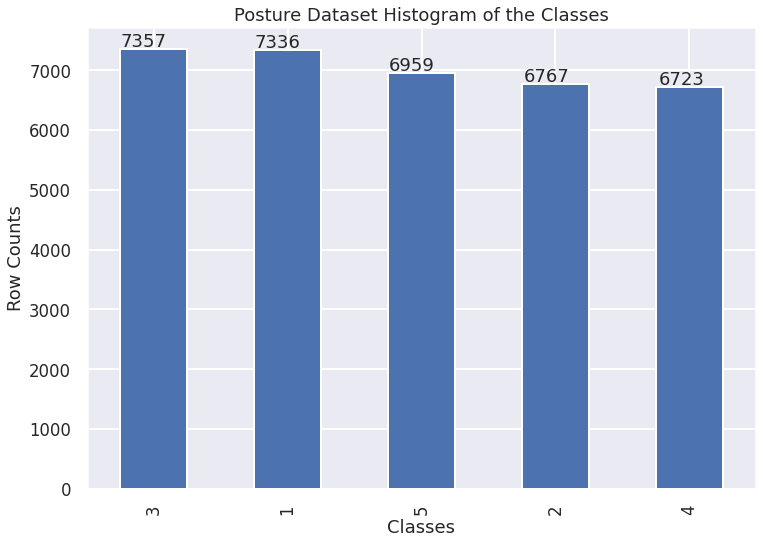

In [ ]:
ax = data.Class.value_counts().plot(kind='bar')
try:
  ax.bar_label(ax.containers[0])
except:
  for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.title("Posture Dataset Histogram of the Classes")
plt.xlabel("Classes")
plt.ylabel("Row Counts")
plt.show()

## Data preprocessing

In [ ]:
cat_columns = data.select_dtypes('object').columns.tolist()
for col in cat_columns:
  data[col] = data[col].astype('category').cat.codes
data.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,3,6.0,109.240478,44.899381,-60.024315,61.033350,85.559458,-18.295491,68.721592,0.169402,-66.863960,11.542282,84.467412,-33.672673,52.229240,136.226905,-13.461600,92.907674,26.103671,-62.525220,-9.119754,82.657635,-32.104225,44.219670,88.622517,-20.210009,48.058413,86.021193,-24.230812,54.593085,80.971477,-27.625913,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597
1,4,11.0,24.330178,101.140373,1.816550,55.473059,131.027370,13.658764,16.883000,148.501225,6.423454,114.212940,38.602086,-61.127214,72.265570,12.157565,-56.796850,92.830339,28.800005,-60.120643,52.767190,93.407573,-0.229293,44.219670,88.622517,-20.210009,48.058413,86.021193,-24.230812,54.593085,80.971477,-27.625913,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597
2,4,13.0,63.498073,17.176245,-60.413507,74.682024,48.333237,-57.479898,32.838805,147.810305,-12.697328,50.741438,137.808138,-16.903903,71.460231,75.724995,-57.773480,32.572369,99.871957,-8.085566,53.522974,97.148466,-11.820767,44.219670,88.622517,-20.210009,48.058413,86.021193,-24.230812,54.593085,80.971477,-27.625913,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597
3,2,14.0,86.767860,74.450010,-46.187383,57.077763,99.699882,-13.512337,52.828546,151.329974,12.972557,59.619855,36.147365,-56.078468,66.259513,144.173187,-6.390248,16.861316,143.212475,34.183860,13.494791,94.610410,12.191463,-2.985673,123.914195,27.534306,71.138877,56.656104,-49.460886,-9.180367,80.449669,13.646088,38.404759,106.030959,0.419250,-41.541234,24.841743,9.02597
4,5,14.0,-2.025544,99.352134,6.365841,76.213345,33.631282,-41.670484,87.056709,61.502402,-59.262181,-29.853791,77.790630,-17.576383,26.685505,136.893558,-31.884217,55.130637,129.133685,-43.232234,61.867149,101.286413,-6.095230,-2.516153,125.257435,-42.207798,28.077631,108.108797,11.555042,-21.859351,103.919267,-55.090304,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597


## Data split

In [ ]:
X, X_test, y, y_test = train_test_split(data[data.columns[2:]], data[data.columns[0]].values, test_size=0.33, random_state=42)

In [ ]:
scale = StandardScaler()
scale.fit(data.iloc[:, 2:].values)

X_scaled = scale.transform(X.values)
X_test_scaled = scale.transform(X_test.values)

X.shape

(23545, 36)

## Deep Neural Network

In [ ]:
from keras.models import Sequential, save_model
from keras.callbacks import EarlyStopping
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam


In [ ]:
len(X_scaled[0])

36

In [ ]:
%%time
# early_stopping_monitor = EarlyStopping(patience=2)
input_shape = (X_scaled.shape[1],)

# Create the new model: model_2
model_1 = Sequential()

# Add the hidden layers
model_1.add(Dense(64, activation='relu', input_shape=input_shape))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(64, activation='relu'))
# model_1.add(Dense(64, activation='relu'))

# Add the output layer
model_1.add(Dense(5, activation='sigmoid'))



CPU times: user 50.6 ms, sys: 0 ns, total: 50.6 ms
Wall time: 52.6 ms


In [ ]:
set(y)

{1, 2, 3, 4, 5}

### Effect of learning rate in optimization

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/100
516/516 [==============================] - 3s 4ms/step - loss: 0.1041 - accuracy: 0.9598 - val_loss: 1.4426 - val_accuracy: 0.9495
Epoch 2/100
516/516 [==============================] - 1s 3ms/step - loss: 0.1028 - accuracy: 0.9604 - val_loss: 1.4982 - val_accuracy: 0.9496
Epoch 3/100
516/516 [==============================] - 1s 3ms/step - loss: 0.1026 - accuracy: 0.9610 - val_loss: 1.5309 - val_accuracy: 0.9502
Epoch 4/100
516/516 [==============================] - 1s 3ms/step - loss: 0.1003 - accuracy: 0.9616 - val_loss: 1.5828 - val_accuracy: 0.9516
Epoch 5/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0998 - accuracy: 0.9620 - val_loss: 1.5820 - val_accuracy: 0.9519
Epoch 6/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0992 - accuracy: 0.9621 - val_loss: 1.5756 - val_accuracy: 0.9519
Epoch 7/100
516/516 [==============================] - 2s 4ms/step - loss: 0.0991 - accuracy: 0.9621 - val_loss: 1.5729 - val_accuracy: 0.9519

 33%|███▎      | 1/3 [02:36<05:13, 156.62s/it]

Epoch 1/100
516/516 [==============================] - 3s 5ms/step - loss: 0.0802 - accuracy: 0.9687 - val_loss: 2.9525 - val_accuracy: 0.9584
Epoch 2/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0766 - accuracy: 0.9698 - val_loss: 3.2731 - val_accuracy: 0.9602
Epoch 3/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0716 - accuracy: 0.9701 - val_loss: 2.9914 - val_accuracy: 0.9604
Epoch 4/100
516/516 [==============================] - 1s 2ms/step - loss: 0.0690 - accuracy: 0.9705 - val_loss: 3.1624 - val_accuracy: 0.9601
Epoch 5/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0677 - accuracy: 0.9708 - val_loss: 3.5399 - val_accuracy: 0.9604
Epoch 6/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0708 - accuracy: 0.9715 - val_loss: 3.6269 - val_accuracy: 0.9611
Epoch 7/100
516/516 [==============================] - 1s 3ms/step - loss: 0.0654 - accuracy: 0.9720 - val_loss: 3.5404 - val_accuracy: 0.9614

 67%|██████▋   | 2/3 [05:02<02:30, 150.06s/it]

Epoch 1/100
516/516 [==============================] - 2s 3ms/step - loss: 0.1155 - accuracy: 0.9797 - val_loss: 4.3174 - val_accuracy: 0.9458
Epoch 2/100
516/516 [==============================] - 1s 3ms/step - loss: 0.2122 - accuracy: 0.9516 - val_loss: 2.9477 - val_accuracy: 0.9326
Epoch 3/100
516/516 [==============================] - 1s 3ms/step - loss: 0.2088 - accuracy: 0.9558 - val_loss: 4.4110 - val_accuracy: 0.9448
Epoch 4/100
516/516 [==============================] - 1s 3ms/step - loss: 0.1962 - accuracy: 0.9564 - val_loss: 3.2364 - val_accuracy: 0.9422
Epoch 5/100
516/516 [==============================] - 1s 3ms/step - loss: 0.2761 - accuracy: 0.9213 - val_loss: 0.8381 - val_accuracy: 0.8631
Epoch 6/100
516/516 [==============================] - 1s 3ms/step - loss: 0.1828 - accuracy: 0.9196 - val_loss: 1.3333 - val_accuracy: 0.9319
Epoch 7/100
516/516 [==============================] - 1s 3ms/step - loss: 0.1197 - accuracy: 0.9555 - val_loss: 2.2505 - val_accuracy: 0.9548

100%|██████████| 3/3 [08:24<00:00, 168.20s/it]


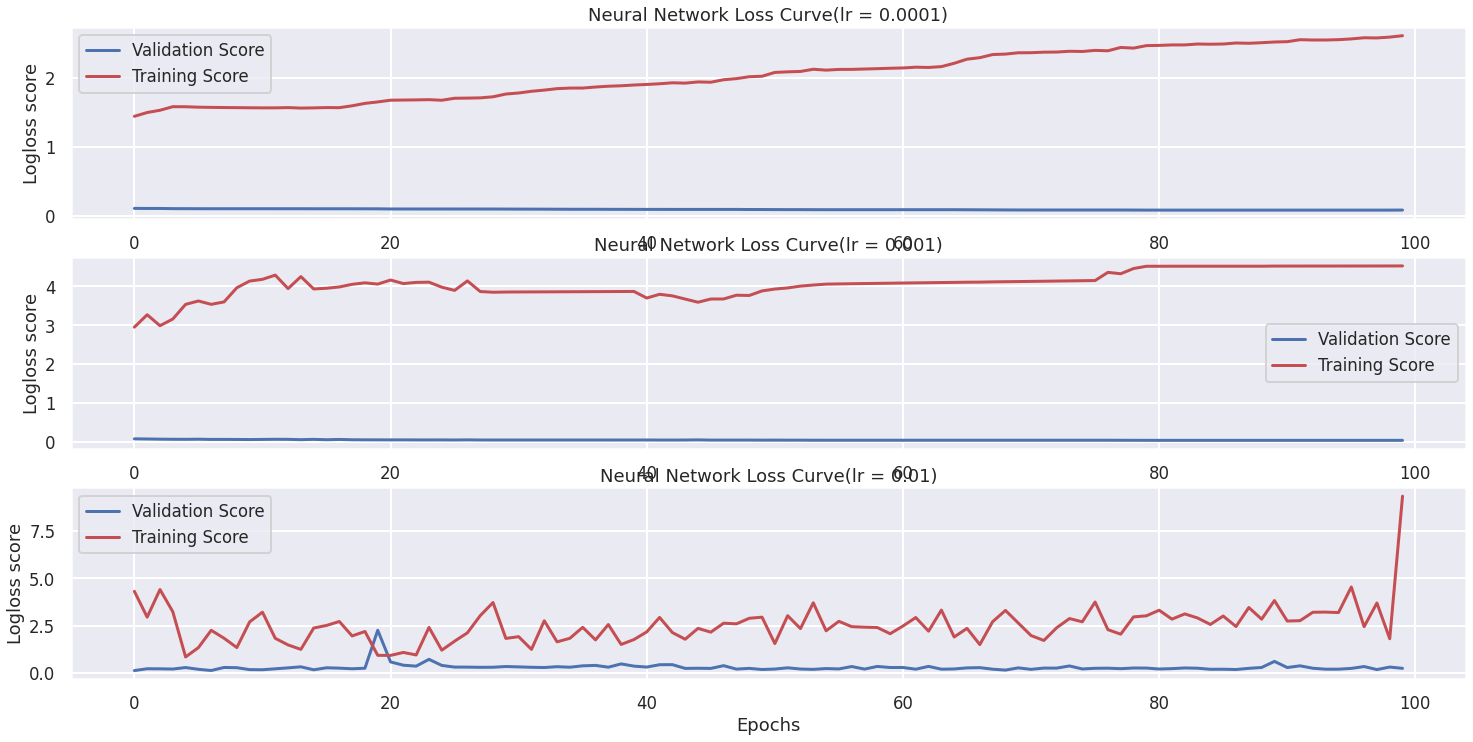

In [ ]:
subs = 310
plt.figure(figsize=(25, 12))
# for lr in tqdm([ 0.0001]):
for lr in tqdm([0.0001, 0.001, 0.01]):
  subs = subs+1
  # Compile model_2
  model_1.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'],)
  # Fit model_1
  model_1_training = model_1.fit(X_scaled, to_categorical(y-1), epochs=100, validation_split=0.3, verbose=True)
  # Create the plot
  plt.subplot(subs)
  plt.plot(model_1_training.history['loss'], color='b', label='Validation Score')
  plt.plot(model_1_training.history['val_loss'], color='r',label='Training Score')
  plt.xlabel('Epochs')
  plt.ylabel('Logloss score')
  plt.legend(loc='best')
  plt.title('Neural Network Loss Curve(lr = {})'.format(lr))
plt.show()


### Effect of number of layers

  0%|          | 0/3 [00:00<?, ?it/s]

363/363 [==============================] - 1s 1ms/step - loss: 0.2994 - accuracy: 0.9634


 33%|███▎      | 1/3 [01:44<03:29, 104.61s/it]

363/363 [==============================] - 1s 2ms/step - loss: 0.2938 - accuracy: 0.9634


 67%|██████▋   | 2/3 [03:36<01:48, 108.94s/it]

363/363 [==============================] - 1s 1ms/step - loss: 0.4475 - accuracy: 0.9671


100%|██████████| 3/3 [05:59<00:00, 119.95s/it]


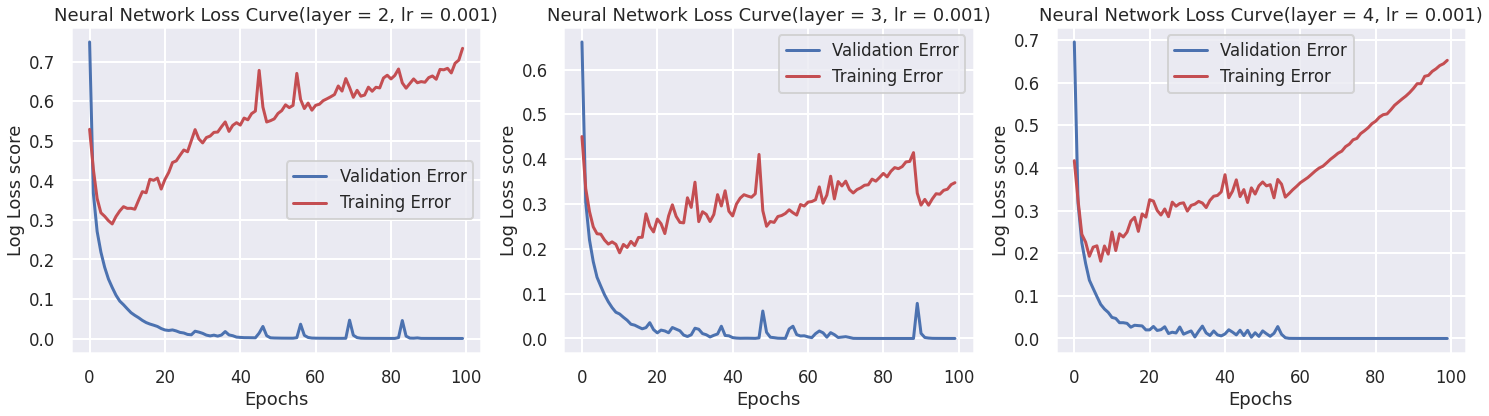

Test Accuracy scores: [0.9634388089179993, 0.963352620601654, 0.9670604467391968]
Loss Scores: [0.2993699908256531, 0.2937714755535126, 0.44752922654151917]
Train Accuracy Scores: []


In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)
input_shape = (X.shape[1],)
subs = 130
losses = []
accs = []
train_accs = []
plt.figure(figsize=(25, 6))
for layer in tqdm(range(1,4)):
  model = Sequential()
  # add first hidden layers
  model.add(Dense(64, activation='relu', input_shape=input_shape))  
  for l in range(layer):
    model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='sigmoid'))
  subs = subs+1
  # Compile model
  model.compile(optimizer=Adam(lr =0.001), loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit model_1
  model_training = model.fit(X_scaled, to_categorical(y-1), epochs=100, validation_split=0.5, verbose=False)
  loss, acc = model.evaluate(X_test_scaled, to_categorical(y_test-1))
  losses.append(loss)
  accs.append(acc)
  # train_accs.append(np.mean(model.history.history.get('val_accuracy'))
  
  # Create the plot
  plt.subplot(subs)
  plt.plot(model_training.history['loss'], color='b', label='Validation Error')
  plt.plot(model_training.history['val_loss'], color='r',label='Training Error')
  plt.xlabel('Epochs')
  plt.ylabel('Log Loss score')
  plt.legend(loc='best')
  plt.title('Neural Network Loss Curve(layer = {}, lr = 0.001)'.format(layer+1))
plt.show()
print("Test Accuracy scores:", accs)
print("Loss Scores:", losses)
print("Train Accuracy Scores:", train_accs)

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)


In [ ]:
# Create the new model: model_2
model_tuned = Sequential()

# Add the hidden layers
model_tuned.add(Dense(32, activation='relu', input_shape=input_shape))
model_tuned.add(Dense(32, activation='relu'))

# Add the output layer
model_tuned.add(Dense(5, activation='sigmoid'))
# Compile model
model_tuned.compile(optimizer=Adam(lr =0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Fit model
%time model_training = model_tuned.fit(X_scaled, to_categorical(y-1), epochs=40, validation_split=0.4, verbose=False, callbacks=[early_stopping_monitor])
loss, acc = model_tuned.evaluate(X_test_scaled, to_categorical(y_test-1), verbose=False)

In [ ]:
print("Test Accuracy:", acc)
print("Train Accuracy:", max(model_training.history['acc']))
print("Loss Score:", loss)

In [ ]:
plt.plot(model_training.history['accuracy'], color='b', label='Validation Error')
plt.plot(model_training.history['val_acc'], color='r',label='Training Error')
plt.xlabel('Epochs')
plt.ylabel('Log Loss score')
plt.legend(loc='best')
plt.title('Neural Network Loss Curve(layer = {}, lr = 0.001)'.format(layer+1))
plt.show()